In [1]:
import pandas as pd
import numpy as np
import time
import sys

In [2]:
answers = pd.DataFrame.from_csv("answers-cs.csv")
answers = answers.reset_index(level=[0],drop=False)
answers = answers[answers.User.notnull()]
answers.head()

,AnsId,CreationDate,QuestionId,User
0,8,2010-08-16T20:11:04.240,2,14
1,9,2010-08-16T20:16:17.470,6,77
2,13,2010-08-16T20:31:32.583,12,80
3,16,2010-08-16T20:32:57.867,10,80
4,18,2010-08-16T20:36:48.810,10,90


In [3]:
answers.shape

(11931, 4)

In [4]:
questions = pd.DataFrame.from_csv("questions-cs.csv")
questions = questions.reset_index(level=[0],drop=False)
questions = questions[questions.QuestionId.notnull()]
questions.head()

,QuestionId,Tags
0,2,<ds.algorithms><total-ordering><sorting>
1,3,<ds.algorithms><hamiltonian-paths>
2,4,<np-hardness><set-cover><cc.complexity-theory>
3,5,<ds.algorithms>
4,6,<concurrency><process-algebra><formal-modeling>


In [5]:
answers = pd.merge(answers,questions,how='inner',on=['QuestionId'])
answers.head()

,AnsId,CreationDate,QuestionId,User,Tags
0,8,2010-08-16T20:11:04.240,2,14,<ds.algorithms><total-ordering><sorting>
1,20,2010-08-16T20:40:01.720,2,95,<ds.algorithms><total-ordering><sorting>
2,9,2010-08-16T20:16:17.470,6,77,<concurrency><process-algebra><formal-modeling>
3,13,2010-08-16T20:31:32.583,12,80,<cc.complexity-theory><lo.logic><computability>
4,48,2010-08-16T21:58:36.573,12,30,<cc.complexity-theory><lo.logic><computability>


In [6]:
#users that post more than one answers per question
print sum(answers.groupby(['User','QuestionId']).count()['AnsId']>1)
## user posts on 6 questions on avarage
print answers.groupby(['User']).count()['AnsId'].mean()

253
6.14683153014


In [7]:
# A couple utilities
get_topics = lambda string: string.strip(">").strip("<").split("><")
df_from_row = lambda row: pd.DataFrame(dict(zip(row.index,[[v] for v in row.values])))

def concat_set_tags(row,topics):
    replicated = pd.concat([df_from_row(row)]*len(topics),axis=0,ignore_index=True)
    replicated.loc[:,'TagSplit'] = pd.Series(topics)
    return replicated

replicate_for_topics = lambda row: concat_set_tags(row,get_topics(row.Tags))

rep_posts = pd.DataFrame()
for idx,row in answers.iterrows():
    rep_posts = rep_posts.append(replicate_for_topics(row),ignore_index=True)
rep_posts.head()

,AnsId,CreationDate,QuestionId,Tags,User,TagSplit
0,8,2010-08-16T20:11:04.240,2,<ds.algorithms><total-ordering><sorting>,14,ds.algorithms
1,8,2010-08-16T20:11:04.240,2,<ds.algorithms><total-ordering><sorting>,14,total-ordering
2,8,2010-08-16T20:11:04.240,2,<ds.algorithms><total-ordering><sorting>,14,sorting
3,20,2010-08-16T20:40:01.720,2,<ds.algorithms><total-ordering><sorting>,95,ds.algorithms
4,20,2010-08-16T20:40:01.720,2,<ds.algorithms><total-ordering><sorting>,95,total-ordering


In [8]:
#The vertext index
qid_tag_idx = rep_posts.groupby(['QuestionId','TagSplit']).count().reset_index(level=[0,1],drop=False)[['QuestionId','TagSplit']]
assert not qid_tag_idx.duplicated().any(),"Vertex index must be unique"
qid_tag_idx = qid_tag_idx.reset_index(level=[0],drop=False) 
qid_tag_idx.head()

,index,QuestionId,TagSplit
0,0,2,ds.algorithms
1,1,2,sorting
2,2,2,total-ordering
3,3,3,ds.algorithms
4,4,3,hamiltonian-paths


In [9]:
ans_short =  pd.merge(rep_posts,qid_tag_idx,how='inner',on=['QuestionId','TagSplit'])[['User','CreationDate','index']]
ans_short.head()

,User,CreationDate,index
0,14,2010-08-16T20:11:04.240,0
1,95,2010-08-16T20:40:01.720,0
2,14,2010-08-16T20:11:04.240,2
3,95,2010-08-16T20:40:01.720,2
4,14,2010-08-16T20:11:04.240,1


## Set timestamps to floats

In [10]:
ans_short.loc[:,'TimeStamp'] = ans_short.CreationDate.apply(
    lambda e: time.mktime(pd.Timestamp(e).timetuple())/(10**8))

In [11]:
## conversion preserves order (almost)
sum(~(ans_short.sort_values(by='TimeStamp').index == ans_short.sort_values(by='CreationDate').index))

0

## Drop cascade (vertex=QuestionId-Tag, Cascade=User)

In [57]:
#mapping of vertex_id and the actual vertex (Qid-tag)
pd.concat([qid_tag_idx['index'],qid_tag_idx['index']],axis=1).to_csv('cascades-cs.txt',index=False,header=False)

with open("cascades-cs.txt","a") as fh:
    fh.write("\n")
    # Groupby attribute defines the cascades
    for k,g in ans_short.groupby(['User']):
        df = g.sort_values(by='TimeStamp')
        fh.write(','.join(map(lambda tup:"%d,%.2f"%(tup[0],tup[1])
                     ,zip(df['index'],df['TimeStamp'])))+"\n")

## Get infered Network

In [143]:
import snap

In [144]:
marginal_gains = {}
graph_size='big'
with open('net-out-edge-%s.info'%graph_size) as f:
    next(f) #drop header
    for i,line in enumerate(f):
        src,dst,_,gain = line.split('/')[:4]
        marginal_gains[(int(src),int(dst))] = float(gain)

In [145]:
def get_graph_out(path):
    with open(path,'r') as f:
        flag = False
        for line in f:
            try:
                src,tgt = line.strip().split(",")
                if src!=tgt:
                    yield line
            except:
                continue

with open('net-out-snap-%s.txt'%graph_size,'w') as f:
    for line in get_graph_out('net-out-%s.txt'%graph_size):
        f.write(line)

In [146]:
infered_net = snap.TNGraph.New()
with open('net-out-snap-%s.txt'%graph_size,'r') as f:
    for line in f:
        src,tgt = line.strip().split(",")
        src,tgt = int(src),int(tgt)
        if not infered_net.IsNode(src):
            infered_net.AddNode(src)
        if not infered_net.IsNode(tgt):
            infered_net.AddNode(tgt)
        infered_net.AddEdge(src,tgt)

In [147]:
net_snap = pd.DataFrame.from_csv('net-out-snap-%s.txt'%graph_size,index_col=False,header=None)
snap_pairs = {}
for k,row in net_snap.iterrows():
    snap_pairs[(row[0],row[1])] = 1

In [148]:
## Verify that output network infor is complete on marginal_gains
## Nbr. of infered edges
print len([t for t in snap_pairs if t not in marginal_gains])
print len(snap_pairs)
print len(marginal_gains)

0
28207
28207


# BUILD CASCADE TREES

### The goal of this section is to reconstruct trees to make within tree 'tag' homophily analysis.

In [149]:
from collections import defaultdict

answers = pd.merge(rep_posts,qid_tag_idx,how='inner',on=['QuestionId','TagSplit'])
answers.loc[:,'TimeStamp'] = answers.CreationDate.apply(
    lambda e: time.mktime(pd.Timestamp(e).timetuple())/(10**8))
answers = answers[['User','index','TimeStamp','AnsId','TagSplit','QuestionId']]

#vertex_id:[list of cascades] e.g. inverted index
cascade_idx = answers.groupby(['index']).User.unique().apply(lambda li: [int(e) for e in li] )
cascade_trees = defaultdict(lambda: snap.TNGraph.New())

In [150]:
#print "edge (%d %d)"%(ni.GetId(), nb_id)
for n_it in infered_net.Nodes():
    for cascade in cascade_idx.loc[n_it.GetId()]:
        if not cascade_trees[cascade].IsNode(n_it.GetId()):
            cascade_trees[cascade].AddNode(n_it.GetId())
        max_gain = -1
        max_src = None
        for src_id in n_it.GetInEdges():
            if cascade in cascade_idx.loc[src_id]:
                if marginal_gains[(src_id,n_it.GetId())]>max_gain :
                    max_gain = marginal_gains[(src_id,n_it.GetId())]
                    max_src = src_id
        if max_src:
            if not cascade_trees[cascade].IsNode(max_src):
                cascade_trees[cascade].AddNode(max_src)
            cascade_trees[cascade].AddEdge(max_src,n_it.GetId())

In [151]:
#Number of infered cascades(users) from total
print len(cascade_trees)
print np.unique(answers.User.values).size

1600
1941


## Identify larger cascades

In [152]:
tree_sizes = [(cascade,cascade_trees[cascade].GetNodes(),cascade_trees[cascade].GetEdges()) 
              for cascade in cascade_trees]
tree_sizes = sorted(tree_sizes,key=lambda tup: tup[1],reverse=True)

In [153]:
#snap_roots = {cascade:snap.GetTreeRootNId(cascade_trees[cascade]) for cascade in cascade_trees}

In [154]:
get_tmstmp = lambda user,idx:answers[(answers.User==user)&(answers['index']==idx)]['TimeStamp'].values[0]

def get_depth(cand_id,tree):
    bfs_tree = snap.GetBfsTree(tree,cand_id,True,False)
    DistVec = snap.TIntPrV()
    snap.GetNodesAtHops(bfs_tree,cand_id,DistVec)
    return max([item.GetVal1() for item in DistVec])

def get_root(user,tree):
    candidates = [(n_it.GetId(),tree) for n_it in tree.Nodes() if n_it.GetInDeg()==0]
    if candidates:
        return max(candidates, key=lambda tup:get_depth(tup[0],tup[1]))[0]
    candidates = [(n_it.GetId(),get_tmstmp(user,n_it.GetId())) for n_it in tree.Nodes()]
    return min(candidates,key=lambda tup:tup[1])[0]
    
#User, root_vertex_id(Qid-tag)
tree_roots = {cascade : get_root(cascade,cascade_trees[cascade])
                  for cascade in cascade_trees}

##  Vertex. Edge. 3-length path counts

In [155]:
infered_topics = np.unique(np.array([n_it.GetId() for n_it in infered_net.Nodes()],dtype=int))
tag_counts = answers[answers.index.isin(infered_topics)].groupby(['TagSplit']).count().reset_index(level=[0],drop=False)[['TagSplit','index']]
tag_counts.rename(columns={'TagSplit':'tag','index':'count'},inplace=True)
tag_counts.head()

,tag,count
0,advice-and-nonuniformity,9
1,advice-request,118
2,ai.artificial-intel,48
3,algebra,29
4,algebraic-complexity,26


## Edges

In [156]:
edges = pd.DataFrame()
for i,cascade in enumerate(cascade_trees):
    src=None
    tgt=None
    split = zip(*[(e.GetSrcNId(),e.GetDstNId()) for e in cascade_trees[cascade].Edges()])
    #Filter out empty cascades
    if split:
        src,tgt = split
        edges = edges.append(pd.DataFrame({'src':src,'tgt':tgt}))
edges = edges.drop_duplicates()

In [157]:
source_tags = pd.merge(answers,edges,how='right',left_on=['index'],right_on=['src'])[['src','tgt','index','TagSplit']]
source_tages = source_tags.drop_duplicates()
tgt_tags = pd.merge(answers,edges,how='right',left_on=['index'],right_on=['tgt'])[['src','tgt','index','TagSplit']]
tgt_tags = tgt_tags.drop_duplicates()

In [158]:
tagged_edges = pd.merge(source_tags,tgt_tags,how='inner',on=['src','tgt'],suffixes=['_src','_tgt'])
tagged_edges = tagged_edges[['src','tgt','TagSplit_src','TagSplit_tgt']].drop_duplicates()

In [159]:
edge_counts = tagged_edges.groupby(['TagSplit_src','TagSplit_tgt']).count().reset_index(level=[0,1],drop=False)[['TagSplit_src','TagSplit_tgt','src']]
edge_counts.rename(columns={'TagSplit_src': 'src','TagSplit_tgt': 'tgt','src':'count'}, inplace=True)
edge_counts.head()

,src,tgt,count
0,advice-request,big-list,1
1,advice-request,books,1
2,ai.artificial-intel,automata-theory,1
3,ai.artificial-intel,decision-trees,1
4,ai.artificial-intel,dfa,1


## vertices by dist to root

In [160]:
tree_depths = {}
for i,cascade in enumerate(cascade_trees):
    DistVec = snap.TIntPrV()
    snap.GetNodesAtHops(cascade_trees[cascade],
                            tree_roots[cascade],
                            DistVec,True)
    #use later for hist of depths
    tree_depths[cascade] = [item.GetVal1() for item in DistVec]

In [161]:
tree_by_hops = {}
for i,cascade in enumerate(cascade_trees):
    for d in tree_depths[cascade]:
        NodeVec = snap.TIntV()
        snap.GetNodesAtHop(cascade_trees[cascade],
                          tree_roots[cascade],d,NodeVec,True)
        tree_by_hops[(cascade,d)] = [v for v in NodeVec]

## Length-3 paths

In [162]:
tree_edges = []
dst = 2
for i,cascade in enumerate(cascade_trees):
    if dst not in tree_depths[cascade]:
        continue
    for n_it in cascade_trees[cascade].Nodes():
        HopV = snap.TIntV()
        snap.GetNodesAtHop(cascade_trees[cascade],
                           n_it.GetId(),dst,
                           HopV,True)
        if len([v for v in HopV])==0:
            continue           
        new_edges = [(n_it.GetId(),
          cascade_trees[cascade].GetNI(v).GetInNId(0),
          v) for v in HopV]
        tree_edges = tree_edges + new_edges

gpar,par,child = zip(*tree_edges)
len_3_paths = pd.DataFrame({'gpar':gpar,'par':par,'child':child})
len_3_paths.head()

,child,gpar,par
0,3654,747,1713
1,3655,747,1713
2,3656,747,1713
3,5806,1713,3656
4,5807,1713,3656


In [163]:
atts = ['gpar','par','child','index','TagSplit']
gpar_tags = pd.merge(answers,len_3_paths,how='right',left_on=['index'],right_on=['gpar'])[atts]
gpar_tags = gpar_tags.drop_duplicates()
par_tags = pd.merge(answers,len_3_paths,how='right',left_on=['index'],right_on=['par'])[atts]
par_tags = par_tags.drop_duplicates()
child_tags = pd.merge(answers,len_3_paths,how='right',left_on=['index'],right_on=['child'])[atts]
child_tags = child_tags.drop_duplicates()

In [164]:
path_feats = ['gpar','par','child','TagSplit_gpar','TagSplit_par','TagSplit_child']
tagged_3_paths = pd.merge(gpar_tags,par_tags,how='inner',on=['gpar','par','child'],suffixes=['_gpar','_par'])
tagged_3_paths = tagged_3_paths.drop_duplicates()
tagged_3_paths = pd.merge(tagged_3_paths,child_tags,on=['gpar','par','child'],how='inner')
tagged_3_paths.rename(columns={'TagSplit': 'TagSplit_child'}, inplace=True)
tagged_3_paths = tagged_3_paths[path_feats].drop_duplicates()
tagged_3_paths.head()

,gpar,par,child,TagSplit_gpar,TagSplit_par,TagSplit_child
0,18,954,1166,pl.programming-languages,reference-request,ds.data-structures
1,18,954,1167,pl.programming-languages,reference-request,skip-lists
2,18,954,1605,pl.programming-languages,reference-request,ds.data-structures
3,18,954,1606,pl.programming-languages,reference-request,functional-programming
4,18,954,1607,pl.programming-languages,reference-request,logic-programming


In [165]:
tag_atts = ['TagSplit_gpar','TagSplit_par','TagSplit_child']
path_counts = tagged_3_paths.groupby(tag_atts).count().reset_index(level=[0,1,2],drop=False)[tag_atts+['gpar']]
path_counts.rename(columns={'TagSplit_gpar':'gpar','TagSplit_par':'par','TagSplit_child':'child','gpar':'count'},inplace=True)
path_counts.head()

,gpar,par,child,count
0,ai.artificial-intel,time-complexity,big-list,1
1,ai.artificial-intel,time-complexity,soft-question,1
2,ai.artificial-intel,time-complexity,survey,1
3,application-of-theory,random-walks,cc.complexity-theory,1
4,approximation-algorithms,cr.crypto-security,reference-request,1


## Calculate 1st transition probability

In [166]:
def normalize(df):
    df.loc[:,'transition_prob'] = df['transition_prob']/df['transition_prob'].sum()
    df.loc[:,'transition_prob'] = df['transition_prob'].cumsum()
    return df

In [167]:
first_order_transpb = pd.merge(tag_counts,edge_counts,how='inner',left_on=['tag'],right_on=['src'],suffixes=['_tag','_edge'])
first_order_transpb.loc[:,'transition_prob'] = first_order_transpb['count_edge']/first_order_transpb['count_tag']
first_order_transpb = first_order_transpb[['src','tgt','transition_prob']]
first_order_transpb = first_order_transpb.groupby(['src']).apply(normalize)
first_order_transpb.head()

,src,tgt,transition_prob
0,advice-request,big-list,0.500
1,advice-request,books,1.000
2,ai.artificial-intel,automata-theory,0.125
3,ai.artificial-intel,decision-trees,0.250
4,ai.artificial-intel,dfa,0.375


## 2nd order calculation

In [168]:
second_order_transpb = pd.merge(path_counts,edge_counts,how='inner',left_on=['gpar','par'],right_on=['src','tgt'],suffixes=['_path','_edge'])
second_order_transpb.loc[:,'transition_prob'] = second_order_transpb['count_path']/second_order_transpb['count_edge']
second_order_transpb = second_order_transpb[['gpar','par','child','transition_prob']]
second_order_transpb = second_order_transpb.groupby(['gpar','par']).apply(normalize)
second_order_transpb.head()

,gpar,par,child,transition_prob
0,ai.artificial-intel,time-complexity,big-list,0.333333
1,ai.artificial-intel,time-complexity,soft-question,0.666667
2,ai.artificial-intel,time-complexity,survey,1.000000
3,application-of-theory,random-walks,cc.complexity-theory,1.000000
4,approximation-algorithms,cr.crypto-security,reference-request,0.500000


## Within-Between tree similarity

In [169]:
import numpy as np
import random
from matplotlib import pyplot

%matplotlib inline

In [170]:
get_tag = lambda nid: qid_tag_idx[qid_tag_idx['index']==nid].TagSplit.values[0]

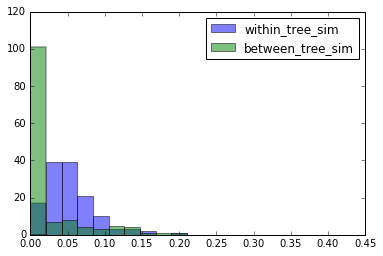

In [190]:
nb_iter = 100 #nuber of trials in each tree
min_size = 50 #min size, probably should be min depth TODO

big_cascades = lambda forest,thresh: (cascade for cascade in forest if forest[cascade].GetNodes()>=thresh)
prob_match = lambda graph,trials: sum([ 
        get_tag(graph.GetRndNId()) == get_tag(graph.GetRndNId())
        for _ in range(trials)])/float(trials)

def prob_match_between(trials):
    c1=0
    c2=0
    while c1==c2:
        c1 = random.choice(cascade_trees.keys())
        c2 = random.choice(cascade_trees.keys())
    ctree_1 = cascade_trees[c1]
    ctree_2 = cascade_trees[c2]
    return sum([ 
        get_tag(ctree_1.GetRndNId()) == get_tag(ctree_2.GetRndNId())
        for _ in range(trials)])/float(trials)
          
probs_within = [prob_match(cascade_trees[cascade],nb_iter) for cascade in big_cascades(cascade_trees,min_size)]
probs_between = [prob_match_between(nb_iter) for _ in big_cascades(cascade_trees,min_size)]

bins = np.linspace(0, .4, 20)        
pyplot.hist(probs_within, bins, alpha=0.5, label='within_tree_sim')
pyplot.hist(probs_between, bins, alpha=0.5, label='between_tree_sim')
pyplot.legend(loc='upper right')
pyplot.show()


## First-order Markov walk

In [191]:
def tag_from(src_id,tree,tags):
    df = pd.DataFrame()
    src_tag = None
    if src_id in tags:
        src_tag = tags[src_id]
    else:
        return None
    df = first_order_transpb[first_order_transpb['src']==src_tag]
    if df.empty:      
        return get_tag(tree.GetRndNId())
    try:
        return df[df['transition_prob']>random.random()]['tgt'].iloc[0]
    except:
        print 'tag: %s'%get_tag(src_id)
        print 'df:'
        print df
        sys.exit()

In [192]:
def walk_and_tag(cascade):
    tags = {}
    bfs_tree = snap.GetBfsTree(cascade_trees[cascade],tree_roots[cascade],True,False)
    tags[tree_roots[cascade]] = get_tag(tree_roots[cascade])
    
    for e_it in bfs_tree.Edges():
        if e_it.GetSrcNId() in tags:
            tags[e_it.GetDstNId()] = tag_from(e_it.GetSrcNId(),cascade_trees[cascade],tags)
    while None in tags.values():
        for e_it in bfs_tree.Edges():
            if e_it.GetSrcNId() in tags:
                tags[e_it.GetDstNId()] = tag_from(e_it.GetSrcNId(),cascade_trees[cascade],tags)
    return tags.values()
    

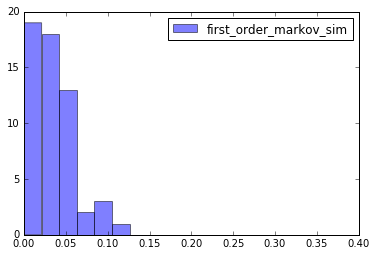

In [193]:
min_size = 50
nb_iter = 100 #nbr of times to sample per tree
##TODO see if need refresh in walk during sampling in nb_iter

get_big = lambda roots,thresh: (cascade for cascade in roots if cascade_trees[cascade].GetNodes()>=thresh)
#iterate only from detected tree roots
sim_first_order = []
for cascade in get_big(tree_roots,min_size):
    mc_dist = walk_and_tag(cascade)
    p = sum([random.choice(mc_dist)==random.choice(mc_dist) for _ in range(nb_iter)])/float(nb_iter)
    sim_first_order.append(p)

bins = np.linspace(0, .4, 20)        
pyplot.hist(sim_first_order, bins, alpha=0.5, label='first_order_markov_sim')
pyplot.legend(loc='upper right')
pyplot.show()

## Second-order markov walk

In [196]:
def tag_3_path(gpar_id,par_id,tree,tags):
    df1 = pd.DataFrame()
    df2 = pd.DataFrame()
    gpar_tag = None
    par_tag = None
    child_tag = None
    
    if gpar_id in tags:
        gpar_tag = tags[gpar_id]
    else:
        return par_tag,child_tag
        
    df1 = first_order_transpb[first_order_transpb['src']==gpar_tag]
    if df1.empty:
        par_tag = get_tag(tree.GetRndNId())
    else :
        par_tag = df1[df1['transition_prob']>random.random()]['tgt'].iloc[0]
    
    df2 = second_order_transpb[(second_order_transpb['gpar']==gpar_tag)
                               &(second_order_transpb['par']==par_tag)]
    if df2.empty:
        child_tag = tag_from(par_id,tree,tags)
    else :
        child_tag = df2[df2['transition_prob']>random.random()]['child'].iloc[0]
        
    return par_tag,child_tag

def tag_row(tree,tags,row):
    #gpar par child ids
    par_tag, child_tag = tag_3_path(row[0],row[1],tree,tags)
    tags[row[1]] = par_tag
    tags[row[2]] = child_tag
    gpar_tag = None
    if row[0] in tags:
        gpar_tag = tags[row[0]]
        
    return pd.Series([row[0],row[1],row[2],gpar_tag,par_tag,child_tag]
            ,index=['gpar','par','child','gpar_tag','par_tag','child_tag'])

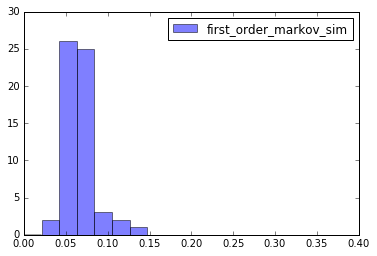

In [197]:
from functools import partial

min_size = 100
nb_iter = 250 #nbr of times to sample per tree

get_big = lambda roots,thresh: (cascade for cascade in roots if cascade_trees[cascade].GetNodes()>=thresh)
#iterate only from detected tree roots
sim_second_order = []
for cascade in get_big(tree_roots,min_size):
    tags = {}
    tree = cascade_trees[cascade]
    tags[tree_roots[cascade]] = get_tag(tree_roots[cascade])
    tag_row_part = partial(tag_row,cascade_trees[cascade],tags)
    
    paths_in_tree = tagged_3_paths[['gpar','par','child']].apply(
        lambda row:tree_test.IsNode(row.iloc[0]) and tree_test.IsNode(row.iloc[1]) and
        tree_test.IsNode(row.iloc[2]),axis=1)
    
    paths_in_tree = tagged_3_paths[paths_in_tree][['gpar','par','child']]
    paths_in_tree = paths_in_tree.apply(lambda row: tag_row_part(row),axis=1)
    nan_part = pd.DataFrame()
    
    while not nan_part.empty:
        paths_in_tree = paths_in_tree.apply(lambda row: tag_row_part(row),axis=1)
        nan_part =  paths_in_tree[(paths_in_tree.gpar_tag.isnull())]
                           #|(nan_part.par_tag.isnull())
                           #|(nan_part.child_tag.isnull())]
    vertex_pool = np.unique(np.hstack([paths_in_tree.gpar.values,
                             paths_in_tree.par.values,
                             paths_in_tree.child.values]))
    matches = 0
    for _ in range(nb_iter):
        s1 = random.choice(vertex_pool)
        s2 = random.choice(vertex_pool)
        tag_s1 = None
        tag_s2 = None
        if (not tag_s1) and not paths_in_tree[paths_in_tree.gpar==s1].empty:
            tag_s1 = paths_in_tree[paths_in_tree.gpar==s1]['gpar_tag'].iloc[0]
        elif (not tag_s1) and not paths_in_tree[paths_in_tree.par==s1].empty:
            tag_s1 = paths_in_tree[paths_in_tree.par==s1]['par_tag'].iloc[0]
        elif (not tag_s1) and not paths_in_tree[paths_in_tree.child==s1].empty:
            tag_s1 = paths_in_tree[paths_in_tree.child==s1]['child_tag'].iloc[0]
        
        if (not tag_s2) and not paths_in_tree[paths_in_tree.gpar==s2].empty:
            tag_s2 = paths_in_tree[paths_in_tree.gpar==s2]['gpar_tag'].iloc[0]
        elif (not tag_s2) and not paths_in_tree[paths_in_tree.par==s2].empty:
            tag_s2 = paths_in_tree[paths_in_tree.par==s2]['par_tag'].iloc[0]
        elif (not tag_s2) and not paths_in_tree[paths_in_tree.child==s2].empty:
            tag_s2 = paths_in_tree[paths_in_tree.child==s2]['child_tag'].iloc[0]
        if tag_s1 == tag_s2:
            matches +=1
    sim_second_order.append(matches/(float(nb_iter)))
        
bins = np.linspace(0, .4, 20)        
pyplot.hist(sim_second_order, bins, alpha=0.5, label='first_order_markov_sim')
pyplot.legend(loc='upper right')
pyplot.show()